In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import math
from urllib.request import urlretrieve


In [15]:
# Load dataset
dataset_url = "https://archive.ics.uci.edu/ml/machine-learning-databases/00409/Daily_Demand_Forecasting_Orders.csv"
local_filename = "Daily_Demand_Forecasting_Orders.csv"

In [16]:
if not os.path.exists(local_filename):
    print("Downloading dataset...")
    urlretrieve(dataset_url, local_filename)

In [2]:
df = pd.read_csv("Daily_Demand_Forecasting_Orders.csv", delimiter=';', decimal=',')
print(f"Dataset loaded with shape: {df.shape}")

Dataset loaded with shape: (60, 13)


In [3]:
# Feature scaling
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(df.iloc[:, :-1].values)  # Features
y_scaler = MinMaxScaler()
y_scaled = y_scaler.fit_transform(df.iloc[:, -1].values.reshape(-1, 1))  # Target

In [4]:
# Parameters
sequence_length = 7  # One week lookback period
train_size = int(len(X_scaled) * 0.8)

In [5]:
# Split data into train and test sets
X_train_data = X_scaled[:train_size]
X_test_data = X_scaled[train_size - sequence_length:]
y_train_data = y_scaled[:train_size]
y_test_data = y_scaled[train_size - sequence_length:]


In [6]:
# Create sequences
X_train, y_train = [], []
X_test, y_test = [], []

In [7]:
for i in range(len(X_train_data) - sequence_length):
    X_train.append(X_train_data[i:i + sequence_length])
    y_train.append(y_train_data[i + sequence_length])

In [8]:
for i in range(len(X_test_data) - sequence_length):
    X_test.append(X_test_data[i:i + sequence_length])
    y_test.append(y_test_data[i + sequence_length])

In [9]:
X_train, y_train = np.array(X_train), np.array(y_train)
X_test, y_test = np.array(X_test), np.array(y_test)

In [10]:
print(f"Training data shape: {X_train.shape}")
print(f"Testing data shape: {X_test.shape}")
# (num_samples, sequence_length, num_features)

Training data shape: (41, 7, 12)
Testing data shape: (12, 7, 12)


In [11]:
# Build LSTM model
model = Sequential([
    LSTM(64, return_sequences=True, input_shape=(sequence_length, X_train.shape[2]), recurrent_dropout=0.1),
    LSTM(64, return_sequences=True, recurrent_dropout=0.1),
    LSTM(64, recurrent_dropout=0.1),
    Dropout(0.2),
    Dense(1)
])

c:\users\hp\appdata\local\programs\python\python39\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [21]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                          │ (None, 7, 64)               │          19,712 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_1 (LSTM)                        │ (None, 7, 64)               │          33,024 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_2 (LSTM)                        │ (None, 64)                  │          33,024 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 1)                   │              65 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 257,477 (1005.77 KB)

 Trainable params: 85,825 (335.25 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 171,652 (670.52 KB)

In [12]:
model.compile(optimizer='adam', loss='mse', metrics=['mae'])



In [13]:
# Visualize model
from tensorflow.keras.utils import plot_model
plot_model(model, to_file='lstm_model.png', show_shapes=True, show_layer_names=True, rankdir='LR')

You must install graphviz (see instructions at https://graphviz.gitlab.io/download/) for `plot_model` to work.


In [14]:
# Early stopping and learning rate scheduler
early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True)
lr_scheduler = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=0.0001)

In [15]:
# Train the model
history = model.fit(
    X_train, y_train,
    epochs=100,
    batch_size=16,
    validation_split=0.2,
    callbacks=[early_stop, lr_scheduler],
    verbose=1
)

Epoch 1/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 6s 709ms/step - loss: 0.1617 - mae: 0.3614 - val_loss: 0.0852 - val_mae: 0.2520 - learning_rate: 0.0010
Epoch 2/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - loss: 0.1189 - mae: 0.2825 - val_loss: 0.0354 - val_mae: 0.1304 - learning_rate: 0.0010
Epoch 3/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - loss: 0.0503 - mae: 0.1576 - val_loss: 0.0211 - val_mae: 0.1373 - learning_rate: 0.0010
Epoch 4/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step - loss: 0.0360 - mae: 0.1389 - val_loss: 0.0569 - val_mae: 0.1962 - learning_rate: 0.0010
Epoch 5/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - loss: 0.0509 - mae: 0.1990 - val_loss: 0.0553 - val_mae: 0.1930 - learning_rate: 0.0010
Epoch 6/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step - loss: 0.0491 - mae: 0.1871 - val_loss: 0.0375 - val_mae: 0.1658 - learning_rate: 0.0010
Epoch 7/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step - loss: 0.0337 - mae: 0.1490 - val_loss: 0.0229 - val_mae: 0.1437 - learning_rate: 0.0010
Epoch 8/100
2/2 ━━━

In [16]:
# Make predictions
train_predictions = model.predict(X_train)
test_predictions = model.predict(X_test)

2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 585ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


In [17]:
# Invert predictions to original scale
train_predictions = y_scaler.inverse_transform(train_predictions)
y_train_inv = y_scaler.inverse_transform(y_train)
test_predictions = y_scaler.inverse_transform(test_predictions)
y_test_inv = y_scaler.inverse_transform(y_test)

In [18]:
# Calculate performance metrics
train_rmse = math.sqrt(mean_squared_error(y_train_inv, train_predictions))
train_mae = mean_absolute_error(y_train_inv, train_predictions)
train_r2 = r2_score(y_train_inv, train_predictions)
train_mape = np.mean(np.abs((y_train_inv - train_predictions) / (y_train_inv + 1e-10))) * 100 
# Mean Absolute Percentage Error (MAPE)

In [19]:
test_rmse = math.sqrt(mean_squared_error(y_test_inv, test_predictions))
test_mae = mean_absolute_error(y_test_inv, test_predictions)
test_r2 = r2_score(y_test_inv, test_predictions)
test_mape = np.mean(np.abs((y_test_inv - test_predictions) / (y_test_inv + 1e-10))) * 100


In [20]:
# Print performance metrics
print(f"Train RMSE: {train_rmse}, Train MAE: {train_mae}, Train R²: {train_r2}, Train MAPE: {train_mape}")
print(f"Test RMSE: {test_rmse}, Test MAE: {test_mae}, Test R²: {test_r2}, Test MAPE: {test_mape}")


Train RMSE: 81.5778964423691, Train MAE: 60.479039056545346, Train R²: 0.12586543524644933, Train MAPE: 18.704723061198226
Test RMSE: 61.651953993690036, Test MAE: 49.800385925292964, Test R²: -0.04718810205774049, Test MAPE: 19.54156702171159


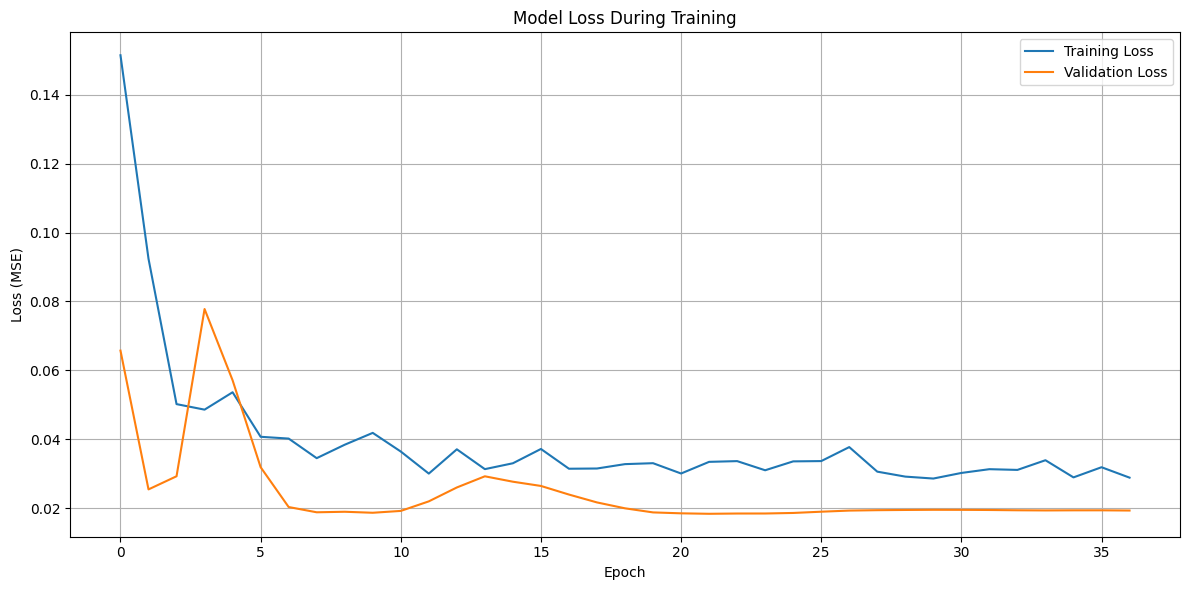

In [36]:
# Plot training loss
plt.figure(figsize=(12, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss During Training')
plt.ylabel('Loss (MSE)')
plt.xlabel('Epoch')
plt.legend(loc='upper right')
plt.grid(True)
plt.tight_layout()
plt.savefig('training_loss.png')
plt.show()

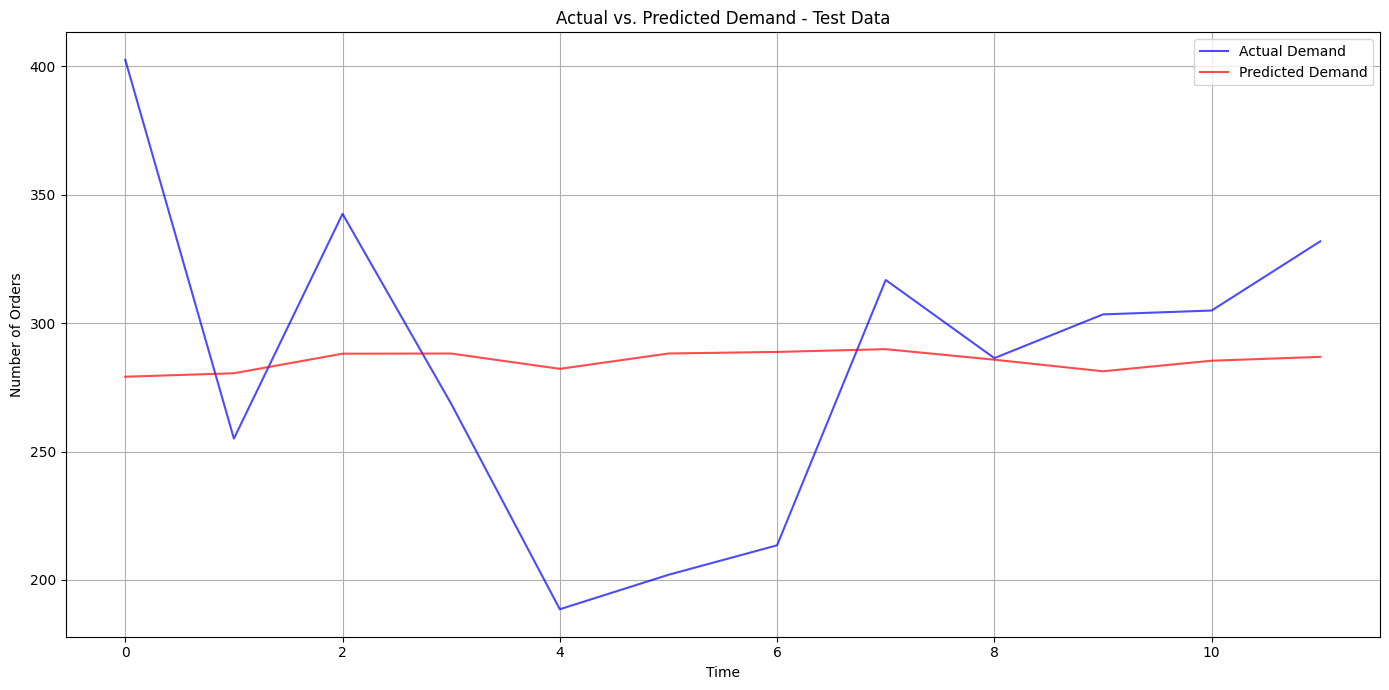

In [37]:
# Plot actual vs predicted for test data
plt.figure(figsize=(14, 7))
plt.plot(y_test_inv, label='Actual Demand', color='blue', alpha=0.7)
plt.plot(test_predictions, label='Predicted Demand', color='red', alpha=0.7)
plt.title('Actual vs. Predicted Demand - Test Data')
plt.ylabel('Number of Orders')
plt.xlabel('Time')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig('test_predictions.png')
plt.show()

In [38]:
# Visualize performance metrics
metrics_names = ['RMSE', 'MAE', 'R²', 'MAPE']
train_values = [train_rmse, train_mae, train_r2, train_mape]
test_values = [test_rmse, test_mae, test_r2, test_mape]

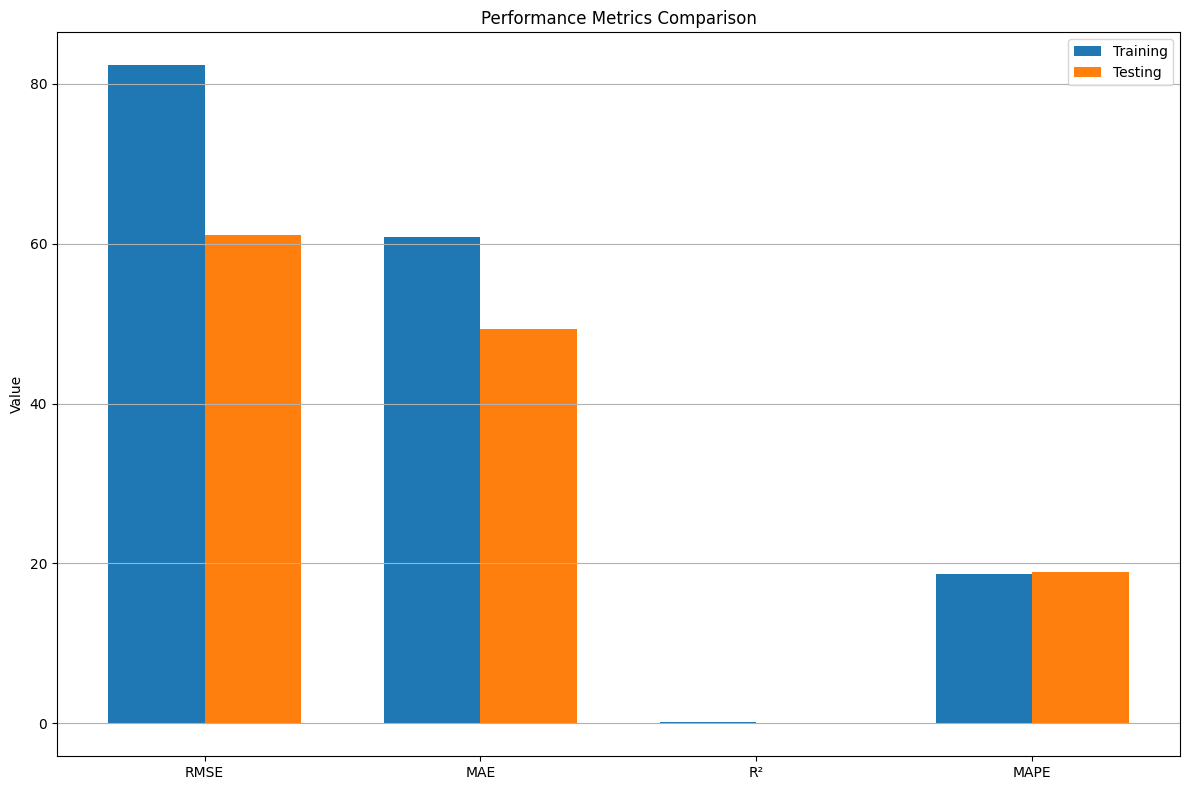

In [39]:
plt.figure(figsize=(12, 8))
x = np.arange(len(metrics_names))
width = 0.35
plt.bar(x - width/2, train_values, width, label='Training')
plt.bar(x + width/2, test_values, width, label='Testing')
plt.title('Performance Metrics Comparison')
plt.xticks(x, metrics_names)
plt.ylabel('Value')
plt.legend()
plt.grid(True, axis='y')
plt.tight_layout()
plt.savefig('performance_metrics.png')
plt.show()